Classifying sequences
---------------------

This Kaggle competition is unusual from a machine learning perspective as it doesn't necessarily require any learning; each sequence is independent, and some can be solved directly. Others can be estimated using ML techniques that may or may not be appropriate for finding their generating function.

ML techniques used here face a problem typical to ML in general:  Just because a function or method appears to solve a sequence, it doesn't necessarily follow that it's the correct function. Being able to describe the existing data doesn't necessarily mean it's possible to accurately predict new data. Claiming the latter without adequate cross-validation and testing would amount to circular reasoning: "If a sequence is solved by x then it's of type x and should be solved by x."

One approach to help mitigate the false positives and circular reasoning problems would be to apply *a priori* knowledge of the properties of a sequence to make a more informed decision about appropriate approaches to try, rather than blindly attempting all possible approaches and scoring/comparing them afterwards. 

In order to do this in an efficient automated fashion, it is presumably necessary to tag the basic properties of each sequence beforehand.

Sequences on the OEIS are tagged with keywords, but the majority of these appear either subjective or require knowledge of  the generating function (http://oeis.org/wiki/Clear-cut_examples_of_keywords). Using them here would obviously be cheating.

The purpose of this notebook is to suggest a few (possibly trivial) functions for automatically tagging fundamental properties of sequences without any reference the generating function. There are also a few examples at the end where the tags might inform decisions. Suggestions for other tags and their potential usefulness are welcomed.

A few possible types of tags:

 - "Basic" - A description of what the sequence looks like, these are what we'll focus on here.
 - "Comparative" -  Tagging a sequence as superficially similar to another (not included here).
 - "OEIS Keywords" - Either similar to "basic" and already applied by OEIS automatically (eg. sign, nonn, short), or the manually applied OEIS keywords.
 - "Solvers" - "This function appears to be solved by this method" (not included here to avoid circular reasoning).

In [1]:
# First import data and define a couple of helper functions
library(numbers) # Used to find GCD
library(ggplot2) # Data visualization
library(readr) # CSV file I/O, e.g. the read_csv function

# Import
data <- read.csv("../input/test.csv", stringsAsFactors=FALSE)
n <- nrow(data)

# Function to get a sequence and convert to numeric
numSeq <- function(r) {  
  sequ <- data[r,2]
  sequ <- as.numeric(strsplit(sequ, ",")[[1]])
  return(sequ)
}

# Tags
meta = c("Static", "Binary", "LimitedStates", "FirstOrder", "Increasing", "Decreasing",
         "Monotonic", "TooBig", "Oscilating", "GCD", "PredictiveMode", "Normal", "TrivialLead",
         "nonn", "short", "sign", "Complete", "MeanMode", "RoundMeanMode", "IntegerMean")

Basic tags
----------

 - **Static**
  - Sequence contains only one number
  - Function:

In [2]:
isStatic <- function(sequ) {
  return(length(unique(sequ))==1)
}

 - **Increasing**
  - Sequence generally increases with length - sum of differences is >0
  - Function and example:

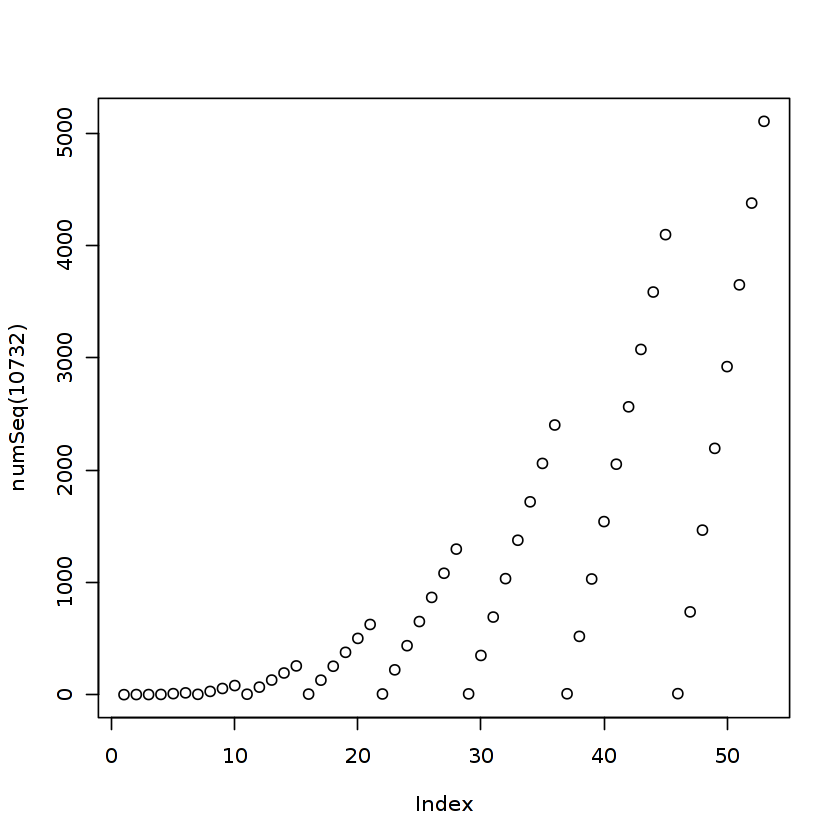

In [3]:
isIncreasing <- function(sequ) {
  d = diff(sequ)
  return(sum(d)>0)
}

plot(numSeq(10732))

 - **Decreasing**
  - Sequence generally decreases with length - sum of differences is <0
  - Function:

In [4]:
isDecreasing <- function(sequ) {
  d = diff(sequ)
  return(sum(d)<0)
}

 - **Monotonic**
  - Sequence either never decreases OR never increases
  - Function and examples:

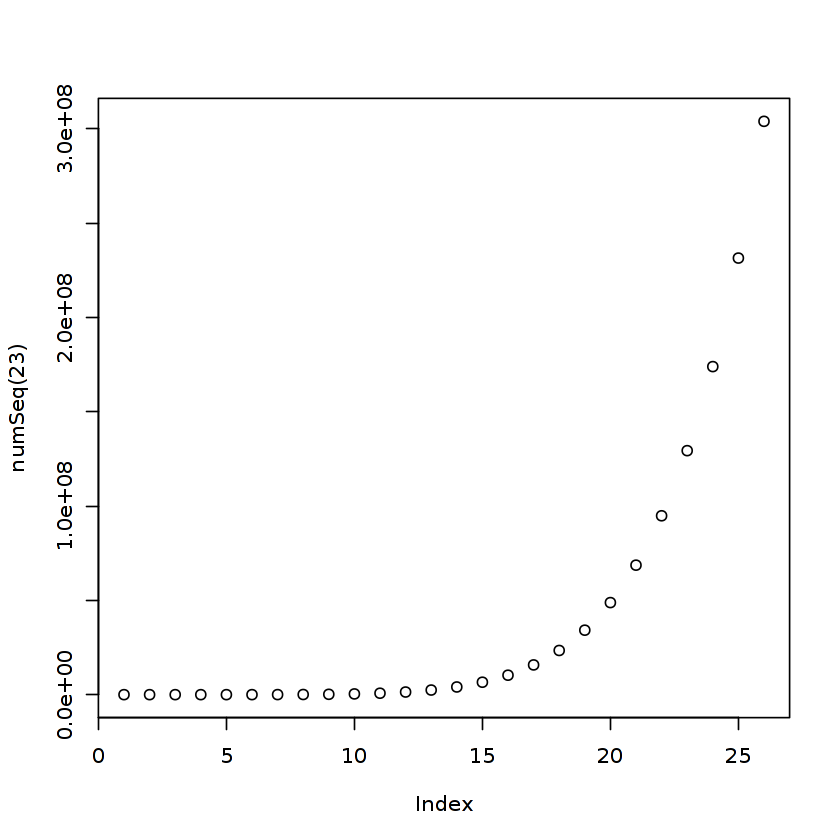

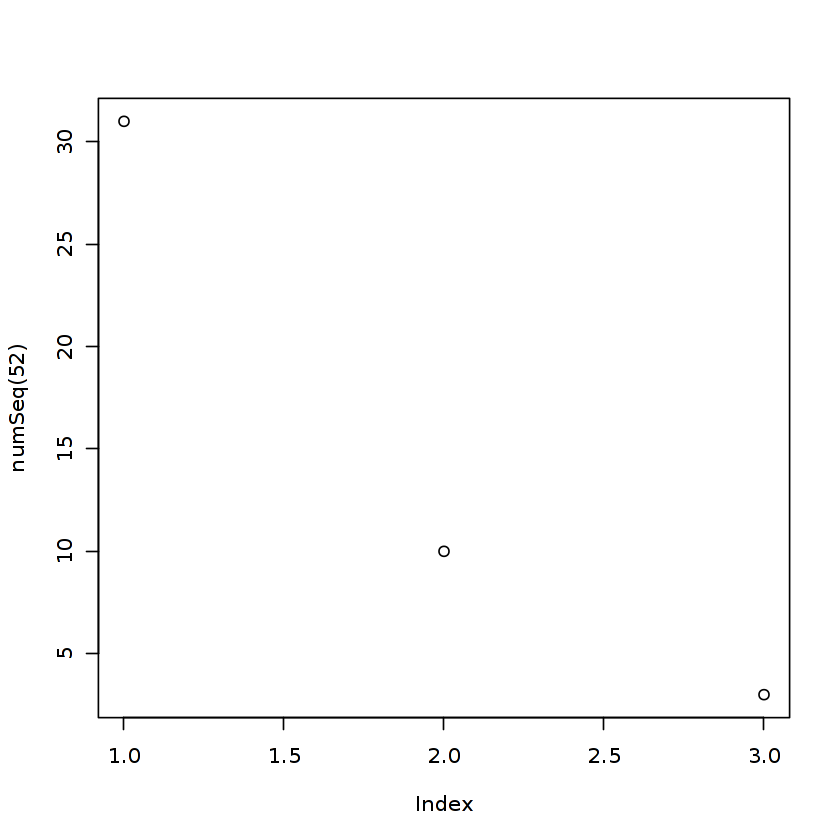

In [5]:
isMonotonic <- function(sequ) {
  d = diff(sequ)
  return(!(any(d>0) & any(d<0)))
}

plot(numSeq(23))
plot(numSeq(52))

 - **Oscillating**
  - Detecting oscillating signals is a whole field of science, but let's keep this simple. If some proportion of differences are >0 AND some proportion of difference are <0 then the sequence is tagged as oscillating.
  - Function and examples:

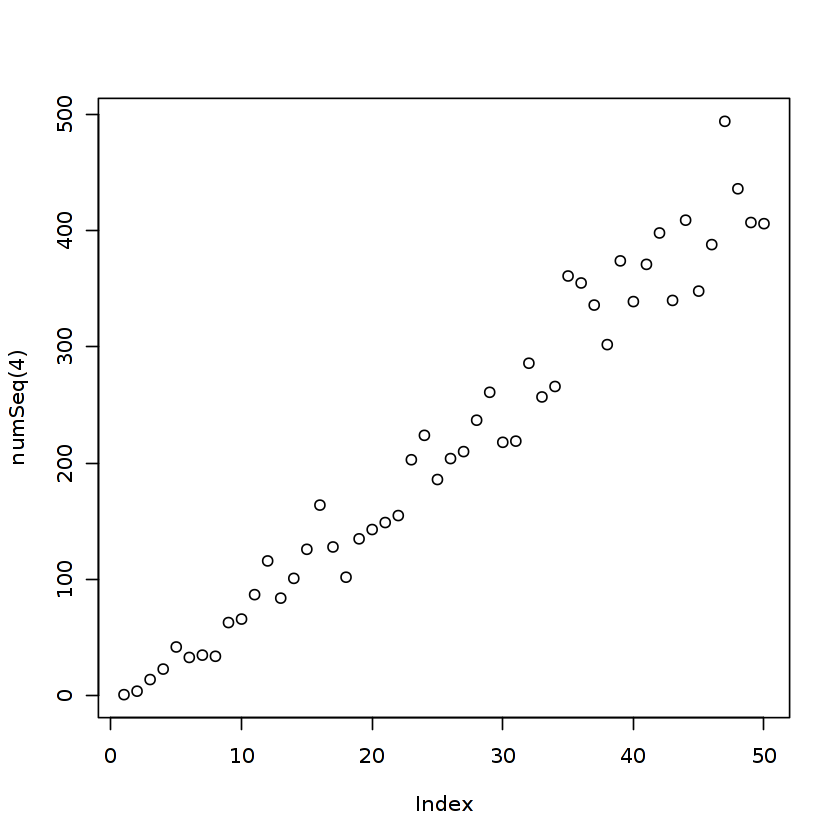

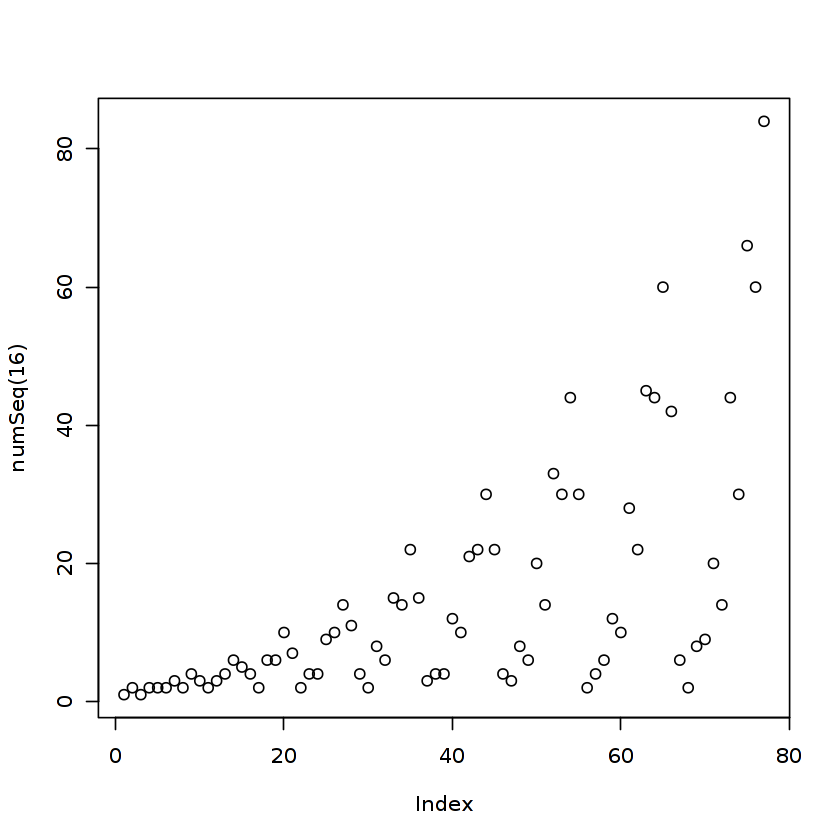

In [6]:
isOscillating <- function(sequ, thresh=0.333) {
  n <- length(sequ)
  propUp <- sum(diff(sequ) > 0) /n
  propDown <- sum(diff(sequ) < 0) /n
  
  return((propUp >= thresh) & (propDown >= thresh))
}

plot(numSeq(4))
plot(numSeq(16))

 - **Binary**
  - Does the sequence have only two states? (Not necessarily just 0 and 1).
  - Function and example: 

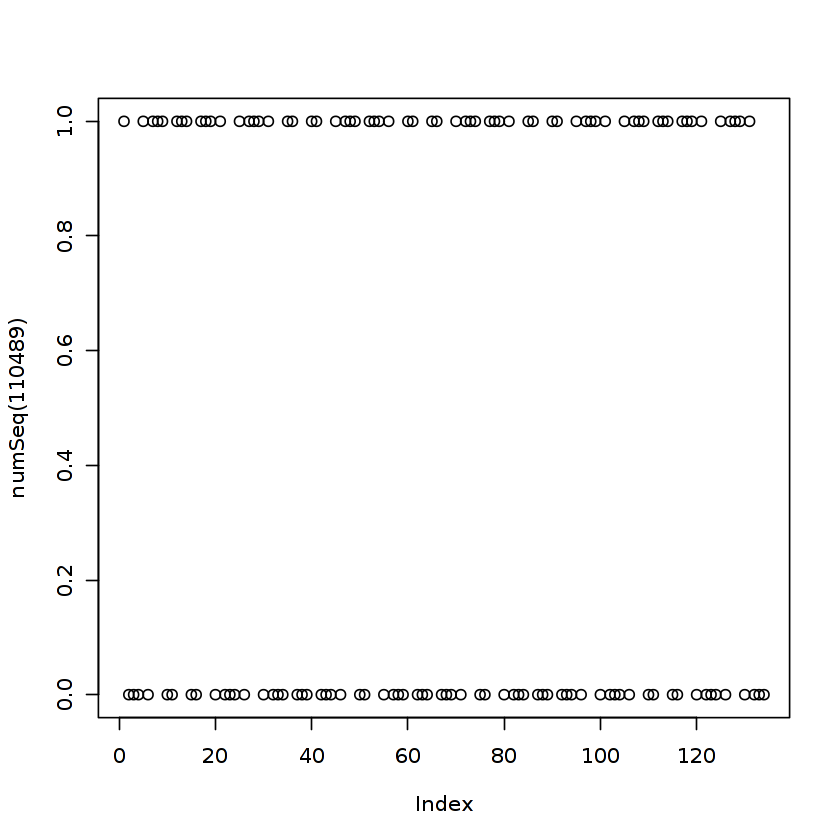

In [7]:
isBinary <- function(sequ) {
  return(length(unique(sequ))==2)
}

plot(numSeq(110489))

 - **LimitedStates**
  - Does the sequence have few states relative to its length?
  - Function and example:

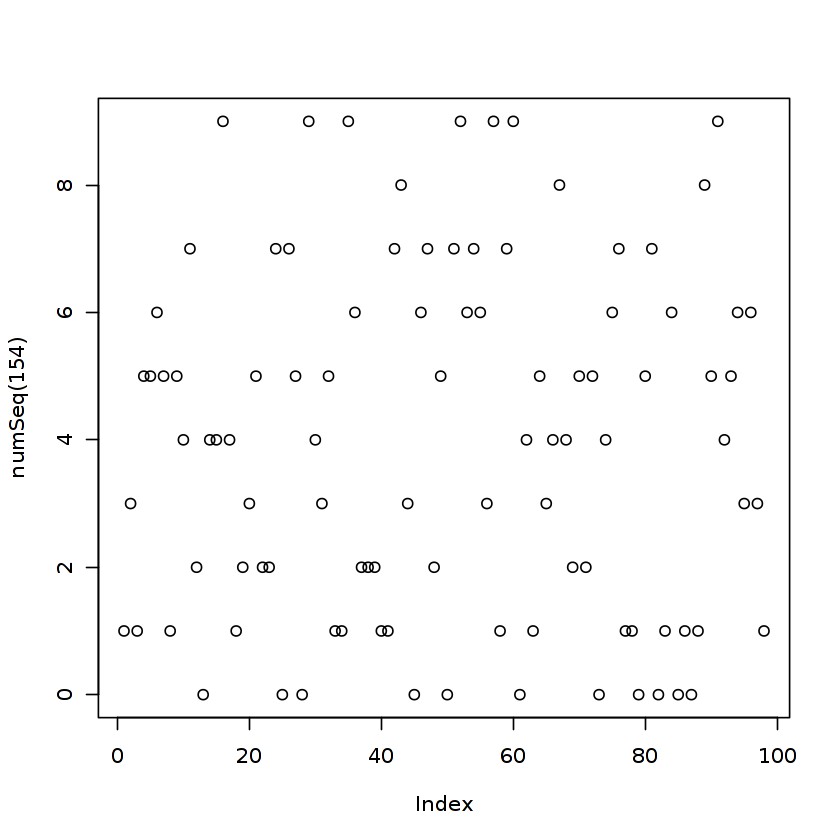

In [8]:
hasLimitedStates <- function(sequ, thresh=0.25) {
  nStates = length(unique(sequ))
  n = length(sequ)
  return(nStates<=(n*thresh))
}

plot(numSeq(154))

 - **FirstOrder**
  - Is the function just a counting function of any base?
  - Function and example:

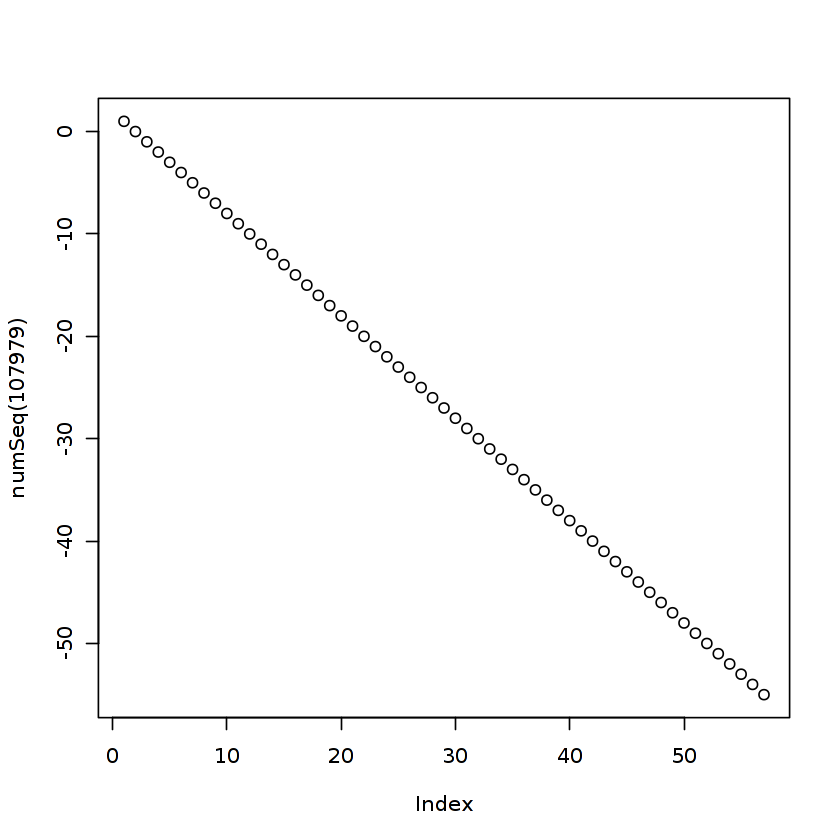

In [9]:
isFirstOrder <- function(sequ) {
  d = diff(sequ)
  return(length(unique(d))==1)
}

plot(numSeq(107979))

 - **TooBig**
  - Contains a term that's bigger than the last consecutive integer available to the system.
  - Function:

In [10]:
isTooFinBig <- function(sequ) {
  return(any(sequ>2^.Machine$double.digits))
}

 - **PredictiveMode**
  - The mode of this sequence appears with a proportion greater than some threshold
  - Function and example:

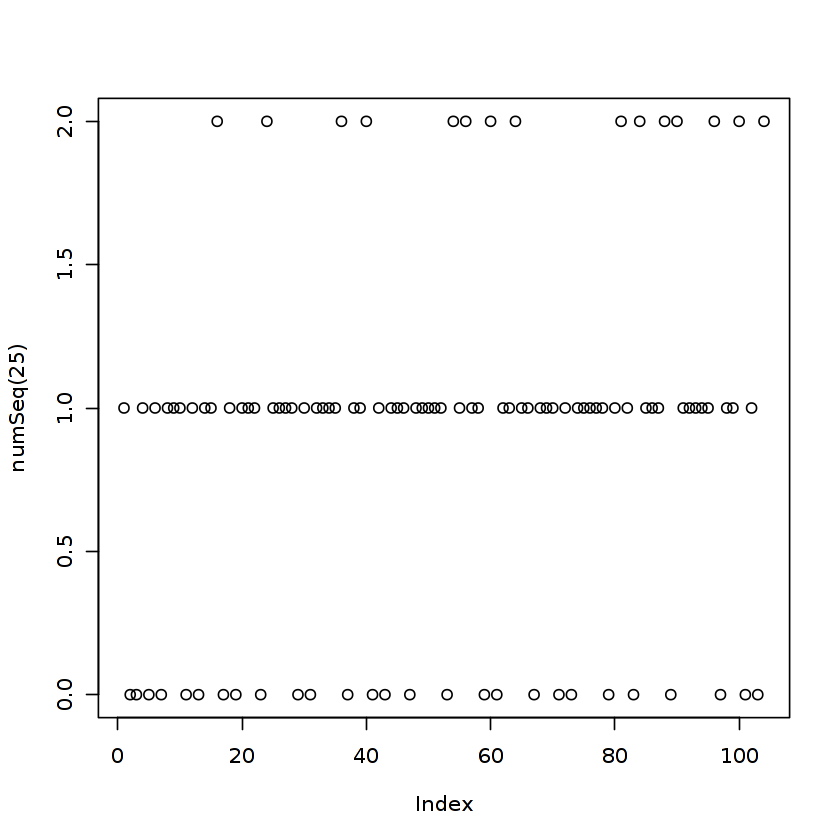

In [11]:
hasPredictiveMode <- function(sequ, thresh=0.333) {
  mode = which.max(tabulate(match(sequ,unique(sequ))))
  modeProp = sum(sequ==mode)/length(sequ)
  
  return(modeProp>=thresh)
}

plot(numSeq(25))

 - **gcd**
  - Sequence has a [greatest common divisor][1] > 1
  - Uses mGCD from numbers library
  - Function and example:

  [1]: https://en.wikipedia.org/wiki/Greatest_common_divisor

In [12]:
hasGCD <- function(sequ) {
  m = length(sequ)
  if (m>=2) 
  {
    return(mGCD(sequ) > 1) 
  } else {
    return(FALSE) 
  }
}

hasGCD(c(2,4,6)) # GCD is 2

[1] TRUE

- **Normal**
  - The terms in this sequence appear to be normally distributed
 - Function and example:

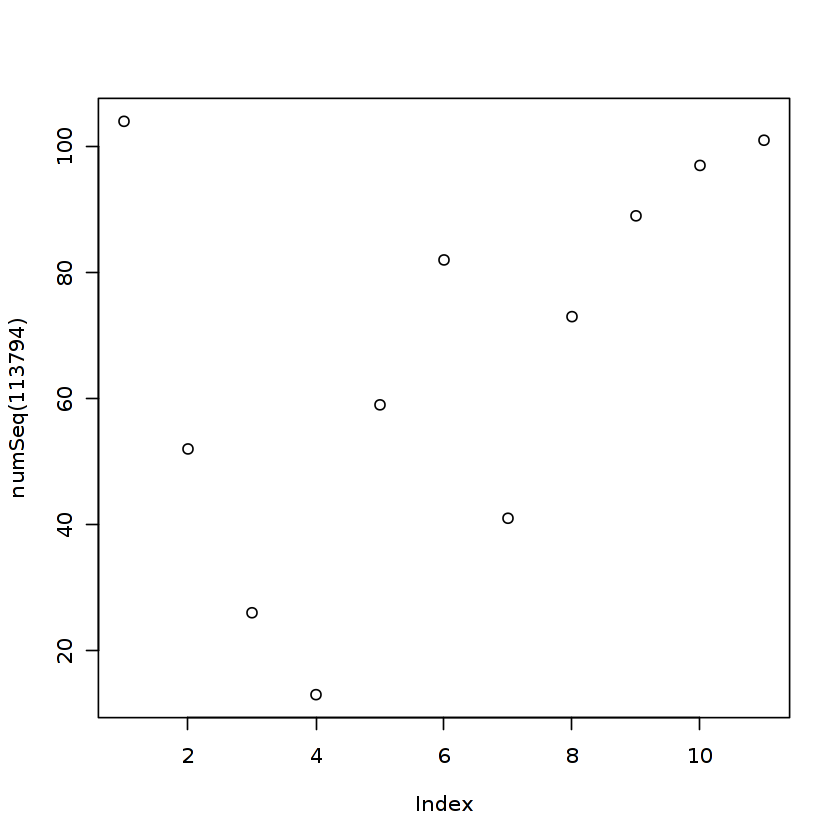

In [13]:
isNormal <- function(sequ, p=0.1) {
  m = length(sequ)
  # Sequence needs to be 3-5000 terms and not all unique
  if (m>=3 & m<=5000 & length(unique(sequ))>1)
  {
    return(shapiro.test(sequ)$p.value > p)
  } else {
    return(FALSE)
  }
}

plot(numSeq(113794))

 - **TrivialLead**
  - The first term of the sequence is not the first term with significance 
  - Function and example:

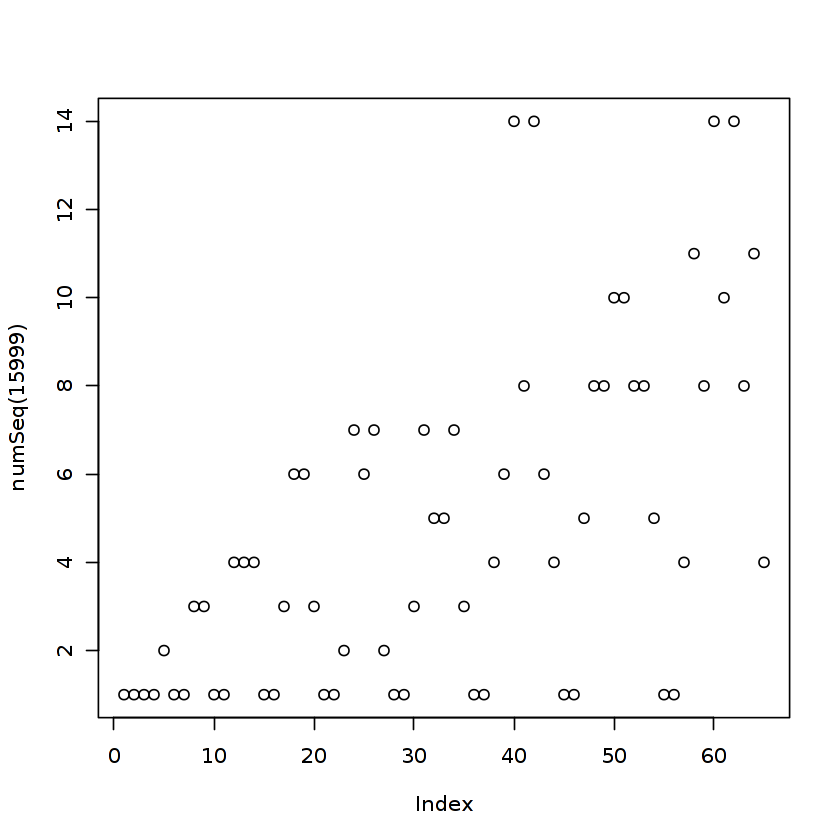

In [14]:
hasTrivialLead <- function(sequ) {
  return(sequ[1]==0 | abs(sequ[1])==1)
}

plot(numSeq(15999))

 - **Sign** - OEIS keyword
  - The first term is negative (or should this be the first non-trivial term?) OR all terms aren't negative. See http://oeis.org/wiki/Clear-cut_examples_of_keywords
  - Function:

In [15]:
isSign <- function(sequ) {
  return(!(all( sequ>=0) | all(sequ*(-1)>=0)))
}

 - **Nonn** - OEIS keyword
  - Opposite of sign - no terms are negative OR all terms are negative (and sequence should be inverted, see http://oeis.org/wiki/Clear-cut_examples_of_keywords

In [16]:
isNonn <- function(sequ) {
  return(all(sequ>=0) | all(sequ*(-1)>=0))
  # or just  all(sequ>=0)?
}

 - **Short**
  - Sequence contains fewer terms in total than threshold
  - Similar to **more** - see http://oeis.org/wiki/Clear-cut_examples_of_keywords
  - Function:

In [17]:
isShort <- function(sequ, thresh=5) {
  return(length(sequ)<=thresh)
}

 - **Complete**
  - Every integer between min(sequence) and max(sequence) present
  - Function and example:

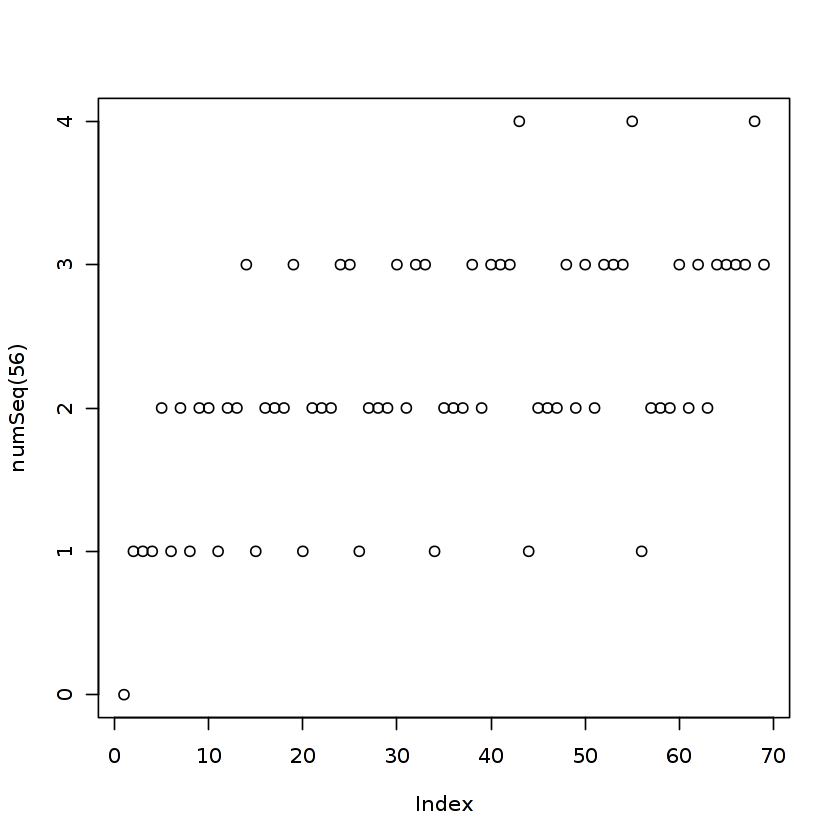

In [18]:
isComplete <- function(sequ) {
  nUnq = length(unique(sequ))
  r = (max(sequ)-min(sequ))+1
  return(nUnq==r)
}

# which(tags[,meta=="Complete"])
plot(numSeq(56))

 - **MeanMode** and **RoundMeanMode**
  - Mean is equal to mode
  - Mean can be rounded, dp=0 rounds to integer; applies tag "RoundMeanMode" 
  - dp>0 only tags where integer mean matches mode; applies tag "MeanMode" 
  - Function and examples:

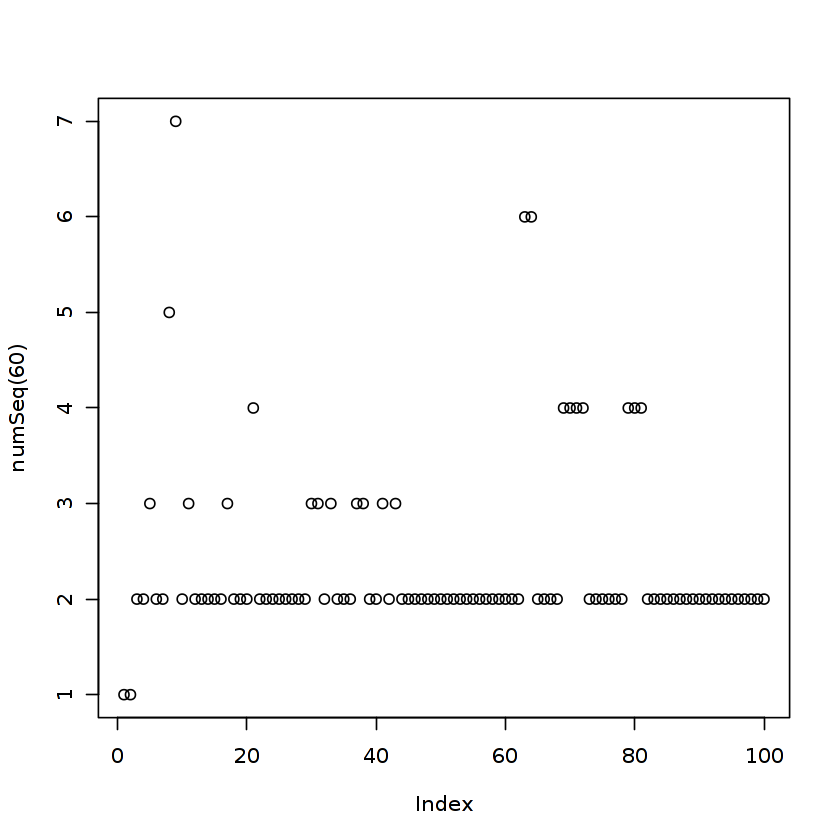

In [19]:
hasMeanMode <- function(sequ, dp=9) {
  mode = which.max(tabulate(match(sequ,unique(sequ))))
  return(round(mean(sequ),dp)==mode)
}

# which(tags[,meta=="RoundMeanMode"])
plot(numSeq(60))

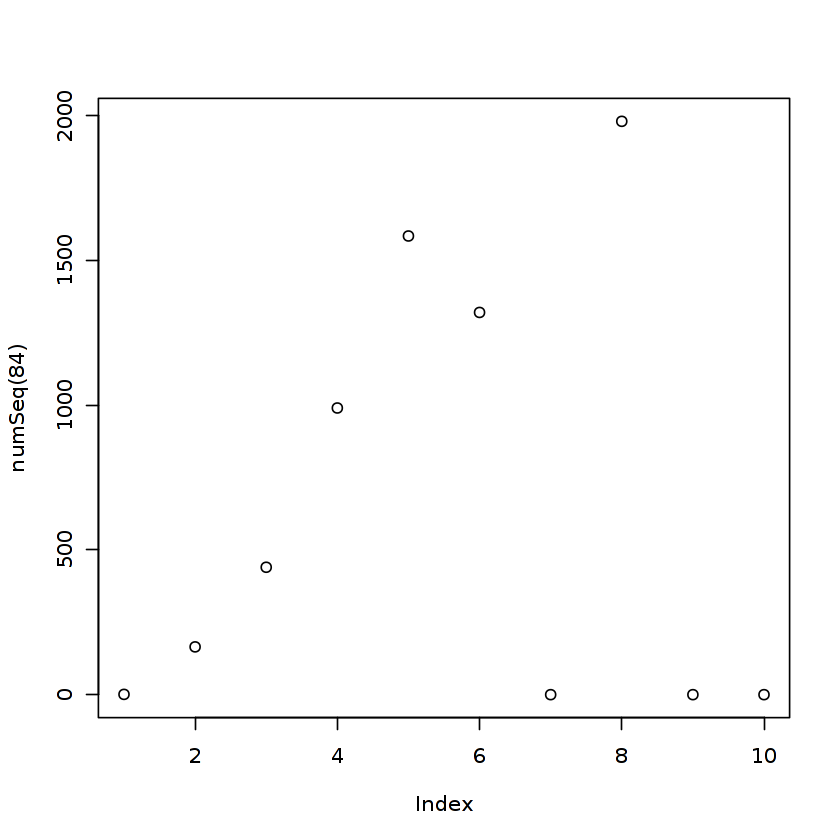

In [20]:
# IntegerMean
hasIntegerMean <- function(sequ) {
  mn = mean(sequ)
  return(round(mn)==mn)
}

# which(tags[,meta=="IntegerMean"])
plot(numSeq(84))

Tags in test set
-------------------

      [,1]     [,2]     [,3]            [,4]         [,5]         [,6]        
meta  "Static" "Binary" "LimitedStates" "FirstOrder" "Increasing" "Decreasing"
nTags "78"     "1292"   "14408"         "534"        "103470"     "7146"      
      [,7]        [,8]     [,9]         [,10]   [,11]            [,12]   
meta  "Monotonic" "TooBig" "Oscilating" "GCD"   "PredictiveMode" "Normal"
nTags "72975"     "21004"  "23279"      "10153" "4047"           "4577"  
      [,13]         [,14]    [,15]   [,16]  [,17]      [,18]     
meta  "TrivialLead" "nonn"   "short" "sign" "Complete" "MeanMode"
nTags "71068"       "107518" "3514"  "6327" "10189"    "59"      
      [,19]           [,20]        
meta  "RoundMeanMode" "IntegerMean"
nTags "2177"          "25594"      


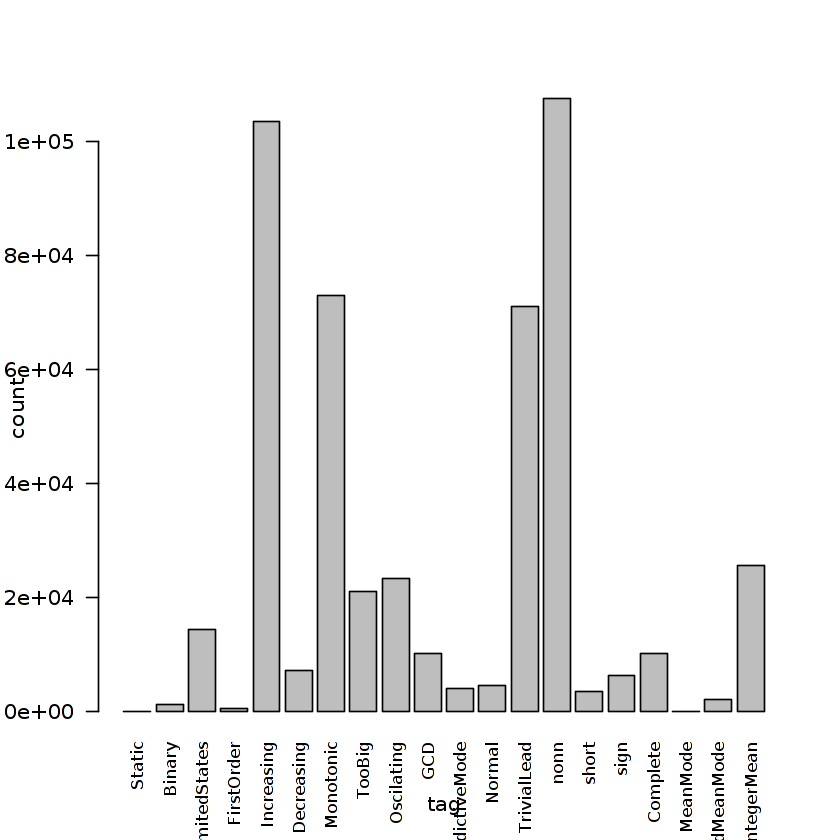

In [21]:
tagSeq <- function(sequ, meta)
{
  
  t = matrix(nrow = 1, ncol = length(meta))
  
  ti = 1
  t[,ti] = isStatic(sequ); ti=ti+1
  t[,ti] = isBinary(sequ); ti=ti+1
  t[,ti] = hasLimitedStates(sequ); ti=ti+1
  t[,ti] = isFirstOrder(sequ); ti=ti+1
  t[,ti] = isIncreasing (sequ); ti=ti+1
  t[,ti] = isDecreasing (sequ); ti=ti+1
  t[,ti] = isMonotonic(sequ); ti=ti+1
  t[,ti] = isTooFinBig(sequ); ti=ti+1
  t[,ti] = isOscillating(sequ); ti=ti+1
  t[,ti] = hasGCD(sequ); ti=ti+1
  t[,ti] = hasPredictiveMode(sequ); ti=ti+1
  t[,ti] = isNormal(sequ); ti=ti+1
  t[,ti] = hasTrivialLead(sequ); ti=ti+1
  t[,ti] = isNonn(sequ); ti=ti+1
  t[,ti] = isShort(sequ); ti=ti+1
  t[,ti] = isSign(sequ); ti=ti+1
  t[,ti] = isComplete(sequ); ti=ti+1
  t[,ti] = hasMeanMode(sequ,9); ti=ti+1
  t[,ti] = hasMeanMode(sequ,0); ti=ti+1
  t[,ti] = hasIntegerMean(sequ); ti=ti+1

  return(list(t,meta[t]))
}

options(warn=-1)
step = FALSE
tags = matrix(nrow = n, ncol = length(meta))
for (r in 1:n)
{
  sequ = numSeq(r)
  t = tagSeq(sequ, meta)
  tags[r,] = t[[1]]
  
  if (step)
  {
    plot(sequ)
    print(meta[t])
    
    # Report
    pcd = paste("(", round(r/n*100, 2), "%)", sep="")
    cat("Done row", r, "/", n, pcd, "\n", sep=" ")
    scan(n=1)
  }
}

nTags = colSums(tags)
print(rbind(meta, nTags))
barplot(nTags, xlab = "tag", ylab = "count", names.arg=meta, cex.names=0.8, las=2)

Examples
--------

A few examples where basic tags might inform the approach to solving the sequence. More ideas appreciated.

 - Sequences tagged with predictive modes might contribute the most to the mode benchmark score. Perhaps sequences without a predictive mode should have a higher threshold before resorting to the mode prediction.
 - Polynomial fit to monotonic sequence (27): The original sequence is monotonic, fit isn't. This probably isn't a good fit for predicting new data, regardless of its MSE or similar goodness of fit measures.

[1] "Original:"


[[1]]
[1] "Increasing"  "Monotonic"   "TrivialLead" "nonn"

[1] "Predicted:"


[[1]]
[1] "Increasing" "nonn"

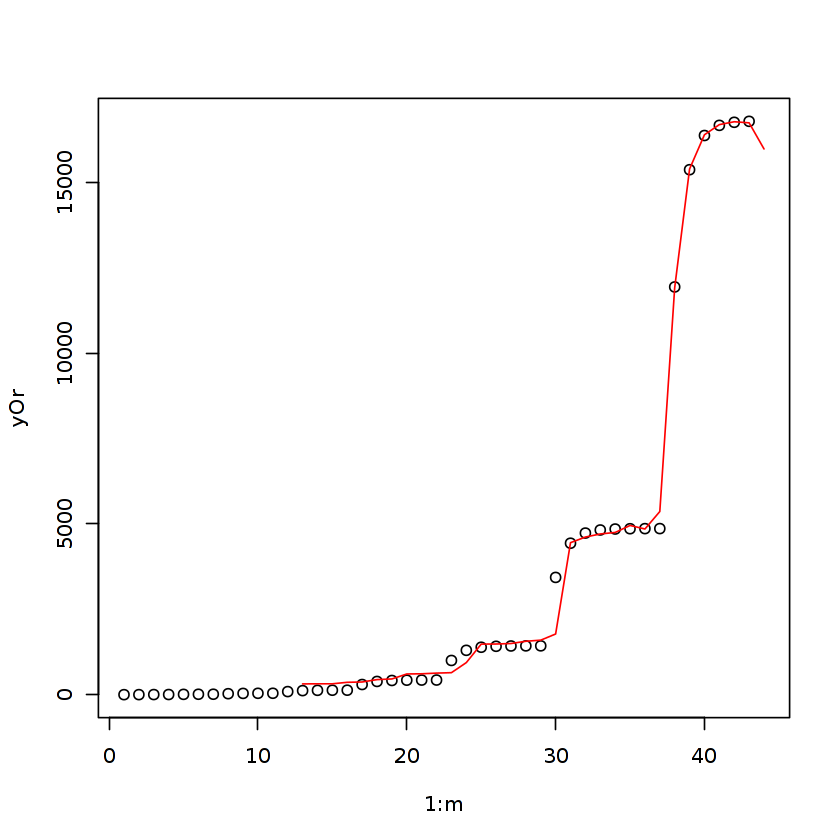

In [22]:
sequ <- numSeq(27) # Get sequence 27
pp = 12 # Fit with pp previous points
m = length(sequ)

yOr <- sequ
y <- data.frame(y=yOr[(pp+1):m])
x <- (pp+1):m
m2 <- length(x)

# Create forumula and data frame for fitting
fStr <- "y~"
for (ppi in 1:pp)
{
  # For each previous value of y
  # Add to formulaString
  fStr <- paste(fStr, "+x", ppi, sep="")
  
  # Create new column (rolling window of previous values)
  nC <- yOr[(pp-(ppi-1)):(m-ppi)]
  # Append to data frame
  y <- data.frame(y, nC)
  # Apply column name
  colnames(y)[ppi+1] <- paste("x", ppi, sep ="")
}

# Do fit
f <- lm(formula(fStr), data=y)

# Predict next point
newData = as.data.frame(y[,2:(pp+1)])
colnames(newData) <- colnames(y)[2:(pp+1)]
newData[m2+1,] <- yOr[m:((m+1)-(pp))]
yP <- round(predict(f, newdata=newData))

# Plot original and fit
gYLim = range(min(min(yOr),min(yP)),max(max(yOr),max(yP)))
gXLim = range(1,(m+1))
plot(1:m, yOr, ylim=gYLim, xlim=gXLim)
lines((pp+1):(m+1), yP, col="red")

# Tag original sequence
print("Original:")
tagSeq(sequ, meta)[2]
# Tag predicted sequence
print("Predicted:")
tagSeq(yP, meta)[2]

 - Reduce penalisation of higher order coefficients in oscillating fits.
 - Predictions for binary or limited state sequences are less likely to be correct if they predict a new state.
 - Anything tagged with first order is very short, or very easy to solve.

## Tag heatmap ##

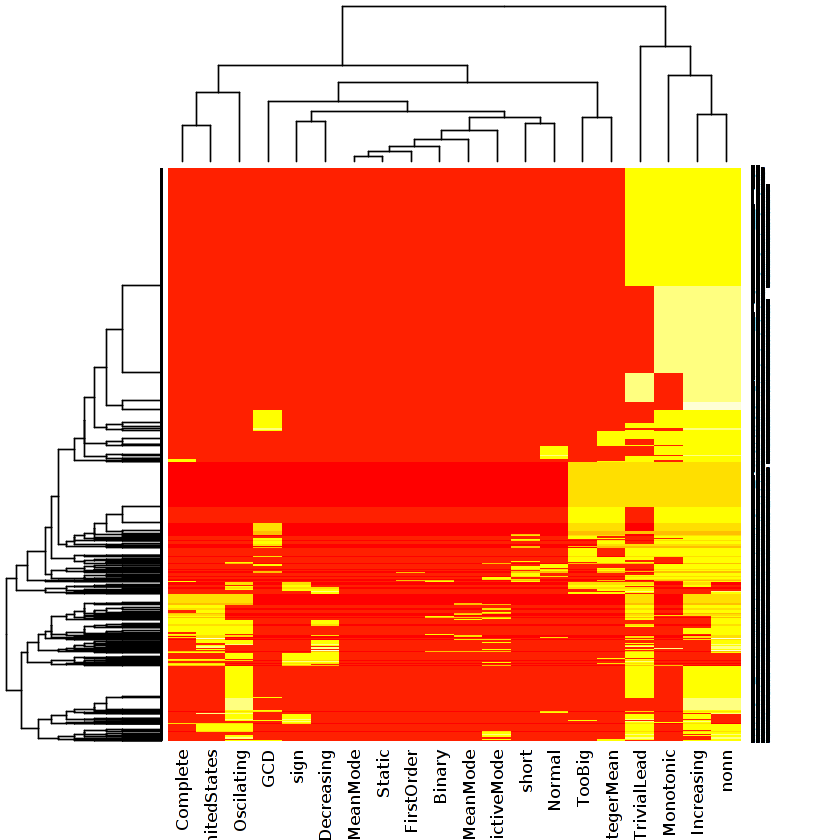

In [23]:
# Number of rows to plot
nPlt = 6000
# Sample nPlt rows randomly
idx <- sample(1:n, nPlt, replace=FALSE)
# Plot as heatmap with clustering in x and y
heatmap(tags[idx,]*1, labCol=meta)